# Make Maze

In [5]:
import os
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/My Drive"

os.chdir(path)
os.listdir(path)

Mounted at /content/drive


['Ultraworking - Lights Spreadsheet v1.2.gsheet',
 'Colab Notebooks',
 'Colab',
 'Multi-style_Image_Caption',
 'Anyfile Notepad Files',
 'Untitled0.ipynb',
 'saatt.ipynb',
 'Untitled.ipynb',
 'Untitled1.ipynb',
 'spark-3.0.1-bin-hadoop3.2.tgz',
 'Big_Data_Processing',
 'ml-latest-small',
 'spark-3.0.1-bin-hadoop3.2',
 'sample_libsvm_data.txt',
 'Assessment_edited2',
 'Machine-Learning',
 'data',
 'gbr_predictions.txt',
 'mean_predictions.txt',
 'constant_predictions.txt',
 'dt_predictions.txt',
 'DecisionTree.ipynb',
 'lstm_predictions10.csv',
 'xgboost_predictions2.csv',
 'LSTM',
 'lstmcv_predictions_r.csv',
 'predictions.csv',
 'predictions_baseline.csv',
 'predictions_baseline128.csv',
 'predictions_baseline128_0.1.csv',
 'fold_5_best_model.h5',
 'fold_6_best_model.h5',
 'fold_7_best_model.h5',
 'fold_8_best_model.h5',
 'fold_9_best_model.h5',
 'predictions_baseline142_60_45.csv',
 'fold_2_best_model.h5',
 'fold_3_best_model.h5',
 'fold_4_best_model.h5',
 'fold_0_best_model.h5',
 'f

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation as anim
plt.rcParams["animation.html"] = "jshtml"


def display_position(image, position=None, positions=None, marker='o', marker_size=200, marker_color='b', interval=200):
    fig, ax = plt.subplots()
    ax.axis('off')
    ax.imshow(image)
    if positions is not None:
        y, x = positions[0]
        image = ax.scatter(x, y, marker=marker, s=marker_size, c=marker_color)

        def update(i):
            y_, x_ = positions[i]
            image.set_offsets(np.vstack((x_, y_)).T)

        return anim.FuncAnimation(fig, update, frames=len(positions), interval=interval, repeat=False)
    elif position is not None:
        y, x = position
        ax.scatter(x, y, marker=marker, s=marker_size, c=marker_color)


def display_board(image, board=None, boards=None, marker1='x', marker2='o', marker_size=200,
                  color1='b', color2='r', interval=200):
    fig, ax = plt.subplots()
    ax.axis('off')
    ax.imshow(image)
    if boards is not None:
        board = boards[0]
        y, x = np.where(board > 0)
        player1 = ax.scatter(x, y, marker=marker1, s=marker_size, c=color1)
        y, x = np.where(board < 0)
        player2 = ax.scatter(x, y, marker=marker2, s=marker_size, c=color2)

        def update(i):
            board_ = boards[i]
            y_, x_ = np.where(board_ > 0)
            player1.set_offsets(np.vstack((x_, y_)).T)
            y_, x_ = np.where(board_ < 0)
            player2.set_offsets(np.vstack((x_, y_)).T)

        return anim.FuncAnimation(fig, update, frames=len(boards), interval=interval, repeat=False)
    elif board is not None:
        y, x = np.where(board > 0)
        ax.scatter(x, y, marker=marker1, s=marker_size, c=color1)
        y, x = np.where(board < 0)
        ax.scatter(x, y, marker=marker2, s=marker_size, c=color2)


In [2]:
import numpy as np
from copy import deepcopy


class Environment:
    """Generic environment.
    Reward only depends on the target state.
    """
    def __init__(self):
        self.state = self.init_state()

    def init_state(self):
        state = None
        return state

    @staticmethod
    def get_actions(state):
        actions = [None]
        return actions

    @staticmethod
    def get_transition(state, action):
        probs = [1]
        states = [deepcopy(state)]
        return probs, states

    @staticmethod
    def get_reward(state):
        return None

    @staticmethod
    def is_terminal(state):
        return True

    @staticmethod
    def get_model(state, action):
        probs, states = Environment.get_transition(state, action)
        rewards = [Environment.get_reward(state) for state in states]
        return probs, states, rewards
    
    def step(self, action):
        """Apply action, get reward and modify state.
        Returns reward, stop (``True`` if terminal state).
        """
        reward = None
        stop = True
        if action is not None and action in self.get_actions(self.state):
            probs, states, rewards = self.get_model(self.state, action)
            i = np.random.choice(len(probs), p=probs)
            state = states[i]
            self.state = state
            reward = rewards[i]
            stop = self.is_terminal(state)
        return reward, stop

    
class Agent:
    """Agent. Default policy is purely random."""
    def __init__(self, environment, policy=None):
        if policy is not None:
            self.policy = policy
        else:
            self.policy = self.random_policy
        self.environment = environment
            
    def random_policy(self, state):
        actions = self.environment.get_actions(state)
        probs = np.ones(len(actions)) / len(actions)
        return probs, actions

    def get_action(self, state):
        action = None
        probs, actions = self.policy(state)
        if len(actions):
            i = np.random.choice(len(actions), p=probs)
            action = actions[i]
        return action

class Maze(Environment):
    """Maze."""

    Map = np.ones((2, 2)).astype(int)
    Init_State = (0, 0)
    Exit_States = [(1, 1)]

    def __init__(self):
        super(Maze, self).__init__()

    @classmethod
    def set_parameters(cls, maze_map, init_state, exit_states):
        cls.Map = maze_map
        cls.Init_State = init_state
        cls.Exit_States = exit_states

    def init_state(self):
        return np.array(Maze.Init_State)

    @staticmethod
    def is_valid(state):
        n, m = Maze.Map.shape
        x, y = tuple(state)
        return 0 <= x < n and 0 <= y < m and Maze.Map[x, y]

    @staticmethod
    def get_actions(state=None):
        moves = [(0, 1), (0, -1), (1, 0), (-1, 0)]
        if state is not None:
            actions = []
            for move in moves:
                if Maze.is_valid(state + move):
                    actions.append(move)
        else:
            actions = moves.copy()
        return actions

    @staticmethod
    def get_transition(state, action):
        probs = [1]
        states = [state.copy() + action]
        return probs, states

    @staticmethod
    def get_reward(state):
        return int(tuple(state) in Maze.Exit_States)

    @staticmethod
    def is_terminal(state):
        return tuple(state) in Maze.Exit_States

    @staticmethod
    def get_model(state, action):
        probs, states = Maze.get_transition(state, action)
        rewards = [Maze.get_reward(state) for state in states]
        return probs, states, rewards

    def display(self, states=None, marker='o', marker_size=200, marker_color='b', interval=200):
        shape = (*Maze.Map.shape, 3)
        image = np.zeros(shape).astype(int)
        for i in range(3):
            image[:, :, i] = 255 * Maze.Map
        return display_position(image, self.state, states, marker, marker_size, marker_color, interval)


In [3]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import sparse

In [30]:
maze = Maze()
maze_map = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
       [0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0],
       [0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
       [0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0],
       [0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0],
       [0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
maze.set_parameters(maze_map, (1,0), [(1,20)])
maze = Maze()

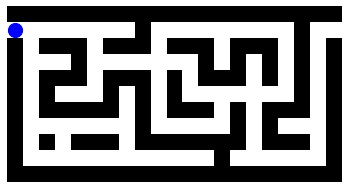

In [31]:
maze.display()

In [32]:
class PolicyEvaluation:
    """Evaluation of a policy."""
    def __init__(self, maze, policy, gamma=0.9, n_iter=200):
        self.maze = maze
        self.policy = policy
        self.gamma = gamma
        self.n_iter = n_iter
        self.shape = maze.Map.shape
        self.actions = maze.get_actions()
        self.action_id = {action: i for i, action in enumerate(self.actions)}
        self.get_transition_matrix()
        self.get_state_action_matrix()
        self.get_rewards()
        self.get_values()
        
    def get_transitions(self, state):
        """Get the possible transitions from a state (policy-dependent)."""
        probs = []
        states = []
        if self.maze.is_valid(state) and not self.maze.is_terminal(state):
            for prob, action in zip(*self.policy(state)):
                probs_, states_ = self.maze.get_transition(state, action)
                probs += list(prob * np.array(probs_))
                states += states_
        return probs, states
    
    def get_transition_matrix(self):    
        """Get the transition matrix from one state to the other (policy-dependent)."""
        n, m = self.shape
        row = []
        col = []
        data = []
        for i in range(n * m):
            state = np.array([i // m, i % m])
            probs, states = self.get_transitions(state)
            if states:
                indices = [state_[0] * m + state_[1] for state_ in states]
                row += len(indices) * [i]
                col += indices
                data += probs
        self.transition = sparse.csr_matrix((data, (row, col)), shape=(n * m, n * m))
        
    def get_rewards(self):
        n, m = self.shape
        rewards = []
        for i in range(n * m):
            reward = 0
            state = np.array([i // m, i % m])
            if self.maze.is_valid(state):
                reward = self.maze.get_reward(state)
            rewards.append(reward)
        self.rewards = rewards
    
    def get_values(self):
        n, m = self.shape
        values = np.zeros(n * m)
        rewards = np.array(self.rewards)
        for t in range(self.n_iter):
            values = self.transition.dot(rewards + self.gamma * values)
        self.values = values        
        
    def get_state_action_matrix(self):    
        """Get the state-action matrix (for deterministic transition).
        Useful for improving policy.
        """
        n, m = self.shape
        row = []
        col = []
        data = []
        for i in range(n * m):
            state = np.array([i // m, i % m])
            actions = self.maze.get_actions(state)
            for action in actions:
                row.append(i)
                col.append(self.action_id[action])
                _, states = self.maze.get_transition(state, action)
                state_ = states[0]
                # add 1 to make difference with unreachable states
                data.append(state_[0] * m + state_[1] + 1)
        self.state_action = sparse.csr_matrix((data, (row, col)), shape=(n * m, len(self.actions)))
        
    def improve_policy(self):
        n, m = self.shape
        value_matrix = self.state_action.copy()
        value_matrix.data = (self.rewards + self.gamma * self.values)[value_matrix.data - 1]
        actions_id = np.array(value_matrix.argmax(axis=1)).ravel()
        policy = lambda state: [[1], [self.actions[actions_id[state[0] * m + state[1]]]]]
        return policy

In [33]:
# random policy
agent = Agent(Maze())
policy = agent.policy

In [34]:
maze = Maze()

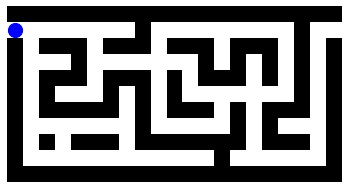

In [35]:
maze.display()

In [36]:
algo = PolicyEvaluation(maze, policy)

In [37]:
values = algo.values

In [38]:
def display_values(values):
    n, m = maze.Map.shape
    image = values.copy().reshape(n, m) + 0.7
    image *= maze.Map
    plt.imshow(image, cmap=cmap)
    plt.axis('off')
    plt.show()

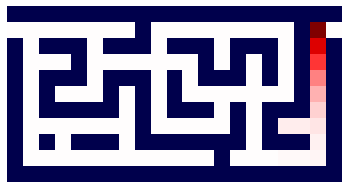

In [39]:
cmap = 'seismic'
display_values(values)

In [40]:
policy = algo.improve_policy()

In [41]:
def get_action(policy, state):
    """Action for a deterministic policy."""
    probs, actions = policy(state)
    return actions[0]

In [42]:
def get_path(policy, n_step=50):
    maze = Maze()
    states = [maze.state]
    for t in range(n_step):
        action = get_action(policy, maze.state)
        _, stop = maze.step(action)
        states.append(maze.state)
        if stop:
            break
    return states

In [43]:
states = get_path(policy)

In [44]:
maze = Maze()

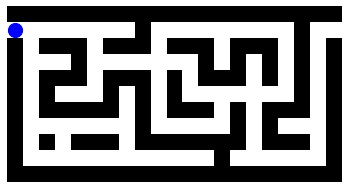

In [45]:
animation = maze.display(states)

In [46]:
animation

In [22]:
class PolicyIteration(PolicyEvaluation):
    """Policy iteration."""
    
    def __init__(self, maze, gamma=0.9, n_iter=200):
        agent = Agent(maze)
        policy = agent.policy
        super(PolicyIteration, self).__init__(maze, policy, gamma, n_iter)   

    def evaluate_policy(self):
        self.get_transition_matrix()
        self.get_values()        
    
    def is_same_policy(self, policy):
        n, m = self.shape
        for i in range(n * m):
            state = np.array([i // m, i % m])
            if self.maze.is_valid(state) and get_action(policy, state) != get_action(self.policy, state):
                return False
        return True
        
    def get_policy(self):
        while 1:
            policy = self.improve_policy()
            if self.is_same_policy(policy):
                break
            self.policy = policy
            self.evaluate_policy()
        return policy

In [23]:
algo = PolicyIteration(maze)

In [24]:
policy = algo.get_policy()

In [25]:
states = get_path(policy)

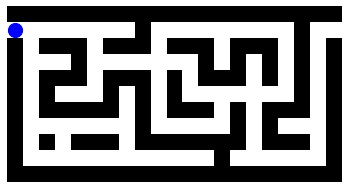

In [26]:
animation = maze.display(states)

In [27]:
animation